<a href="https://colab.research.google.com/github/Camnhung71/IEEE_FRAUD_DETECTION/blob/main/FRAUD_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 1. Tải những thư viện cần thiết

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns



# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

from datetime import datetime
# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.utils import resample
from imblearn.under_sampling import ClusterCentroids,RandomUnderSampler,AllKNN
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency
## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc



/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



# 2. Dữ liệu

In [ ]:
train_identity = pd.read_csv("/content/gdrive/MyDrive/Học máy/ieee-fraud-detection/train_identity.csv")
test_identity = pd.read_csv("/content/gdrive/MyDrive/Học máy/ieee-fraud-detection/test_identity.csv")
train_transaction = pd.read_csv("/content/gdrive/MyDrive/Học máy/ieee-fraud-detection/train_transaction.csv")
test_transaction = pd.read_csv("/content/gdrive/MyDrive/Học máy/ieee-fraud-detection/test_transaction.csv")
sub = pd.read_csv('/content/gdrive/MyDrive/Học máy/ieee-fraud-detection/sample_submission.csv')

In [ ]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [ ]:
train_identity.shape

(144233, 41)

In [ ]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_transaction.shape

(590540, 394)

# 2. Kết hợp dữ liệu

Kết hợp theo các key bên tập train_transaction với cột Transaction_ID được chỉ định để kết nối với hai tập.

In [ ]:
train = train_transaction.merge(train_identity, how='left', on='TransactionID')
test = test_transaction.merge(test_identity, how='left', on='TransactionID')

Giải phóng bộ nhớ tránh việc tràn ram

In [ ]:
del train_identity
del test_identity
del train_transaction
del test_transaction
gc.collect()

232

In [ ]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [ ]:
train.shape

(590540, 434)

In [ ]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
test.shape

(506691, 433)

# 3. Phân tích và tiền xử lý dữ liệu

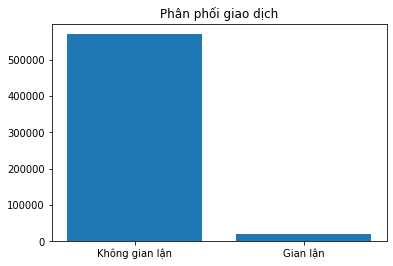

In [ ]:
label = ['Không gian lận', 'Gian lận']
x=train['isFraud'].value_counts().values
plt.bar(label,x)
plt.title('Phân phối giao dịch')
plt.show()

giao dịch gian lận chỉ chiếm 3.5% tập train => dũ liệu bị mất cân bằng nghiêm trọng => cân bằng lại dữ liệu

## 3.1. Thống kê các giá trị bị thiếu

In [ ]:
train_stats = pd.DataFrame(train.isnull().sum()).reset_index()
train_stats.columns = ['cols', 'nulls']
train_stats['percent_nulls'] = 100.0 * train_stats['nulls']/train.shape[0]
train_stats = train_stats.sort_values(by = 'nulls', ascending = False).reset_index(drop = True)
train_stats.head(n = 20)

,cols,nulls,percent_nulls
0,id_24,585793,99.196159
1,id_25,585408,99.130965
2,id_07,585385,99.127070
3,id_08,585385,99.127070
4,id_21,585381,99.126393
5,id_26,585377,99.125715
6,id_27,585371,99.124699
7,id_23,585371,99.124699
8,id_22,585371,99.124699
9,dist2,552913,93.628374


### 3.1.1 drop các trường có giá trị thiếu lớn

In [ ]:
null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]

In [ ]:
null_cols

['dist2',
 'D7',
 'id_07',
 'id_08',
 'id_18',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27']

Loại bỏ 12 trường có giá trị bị thiếu lớn hơn 90% trong tập train và 12 trường tương ứng trong tập test

In [ ]:
train = train.drop(columns = null_cols)

In [ ]:
test = test.drop(columns = ['dist2','D7','id-07','id-08','id-18','id-21','id-22','id-23','id-24','id-25','id-26','id-27'])

### 3.1.2. Tách tập train thành 2 tập là train và train_y

In [ ]:
train_y =  train['isFraud']
train = train.drop(columns=['isFraud'])

### 3.1.3 Lấp đầy dữ liệu bị thiếu

Điền các giá trị còn thiếu của các cột số bằng các giá trị trung bình

In [ ]:
num_cols_train = train.select_dtypes(include=np.number).columns 
num_cols_test = test.select_dtypes(include=np.number).columns

In [ ]:
train[num_cols_train] = train[num_cols_train].fillna(train[num_cols_train].mean())
test[num_cols_test] = test[num_cols_test].fillna(test[num_cols_test].mean())

Điền các gí trị còn thiếu của các biến phân loại bằng mod

In [ ]:
cat_cols_train = train.select_dtypes(include = 'object').columns
cat_cols_test = test.select_dtypes(include = 'object').columns

In [ ]:
train[cat_cols_train] = train[cat_cols_train].fillna(train[cat_cols_train].mode().iloc[0])
test[cat_cols_test] = test[cat_cols_test].fillna(test[cat_cols_test].mode().iloc[0])

## 3.2. Label Encoder

Do các mô hình chỉ làm việc với các dữ liệu dạng số => encode các nhãn chữ => Sử dung label encoder

In [ ]:
def label_encoder(df_):
  cat_cols = []
  for col in df_:
    if df_[col].dtype == 'object':
      cat_cols.append(col)
  for col in cat_cols:
    le = LabelEncoder()
    df_[col] = le.fit_transform(df_[col].astype(str).values)
  return df_

In [ ]:
train = label_encoder(train)
test = label_encoder(test)

## 3.3. Giảm kích thước dữ liệu
Do lượng dữ liệu là khá lớn và RAM của Google Colab là có hạn, khi xử lí dữ liệu hoặc đưa vào các model dễ bị tràn RAM. Vì thế ta sẽ giảm kích thước của dữ liệu tuy nhiên vẫn giữ được giá trị

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train = reduce_mem_usage(train)
test =  reduce_mem_usage(test)

Mem. usage decreased to 517.00 Mb (72.8% reduction)
Mem. usage decreased to 451.33 Mb (72.3% reduction)


# 4. Chuẩn bị dữ liệu

In [ ]:
train_x = train

## 4.1 Xử lý vấn đề chênh lệch nhãn

In [ ]:
train_x, train_y = RandomUnderSampler().fit_resample(train_x, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



## 4.2. Chia tập dữ liệu

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(train_x,train_y,shuffle = True,random_state = 255,test_size = 0.2)

In [ ]:
del train_y
del train_x
gc.collect()

176

# 5. Mô hình

## 5.1. RANDOM FOREST

In [ ]:
forest = RandomForestClassifier(criterion='entropy',random_state=50,n_estimators=100,)
forest.fit(X_train,y_train)
test_y = forest.predict(X_test)

In [ ]:
print('Accuracy score:',accuracy_score(y_test,test_y))
print('F1 score:',f1_score(y_test,test_y))
print('Area Under the Receiver Operating Characteristic Curve:',roc_auc_score(y_test,test_y))
print('Confusion maxtrix',confusion_matrix(y_test,test_y))

Accuracy score: 0.8432131623518025
F1 score: 0.8383636817161387
Area Under the Receiver Operating Characteristic Curve: 0.8430157900933543
Confusion maxtrix [[3609  560]
 [ 736 3361]]


In [ ]:
y_preds = forest.predict_proba(test)
submission = pd.DataFrame({
    'TransactionID' : sub.TransactionID,
    'isFraud' : y_preds[:,1]
})
submission.head()

,TransactionID,isFraud
0,3663549,0.17
1,3663550,0.32
2,3663551,0.37
3,3663552,0.16
4,3663553,0.21


In [ ]:
submission.to_csv('RandomForest.csv', index=False)

In [ ]:
from google.colab import files
files.download('RandomForest.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 5.2. DECISION TREE

In [ ]:
Dtree = DecisionTreeClassifier(min_samples_leaf=4)
Dtree.fit(X_train, y_train)
test_y_Dtree = Dtree.predict(X_test)

In [ ]:
print('Accuracy score:',accuracy_score(y_test,test_y_Dtree))
print('F1 score:',f1_score(y_test,test_y_Dtree))
print('Area Under the Receiver Operating Characteristic Curve:',roc_auc_score(y_test,test_y_Dtree))
print('Confusion maxtrix',confusion_matrix(y_test,test_y_Dtree))

Accuracy score: 0.7930075006048874
F1 score: 0.7895190060278016
Area Under the Receiver Operating Characteristic Curve: 0.7929232951490051
Confusion maxtrix [[3346  823]
 [ 888 3209]]


In [ ]:
y_preds_DT = Dtree.predict_proba(test)
submission_DT = pd.DataFrame({
    'TransactionID' : sub.TransactionID,
    'isFraud' : y_preds_DT[:,1]
})
submission_DT.head()

,TransactionID,isFraud
0,3663549,0.0
1,3663550,0.0
2,3663551,1.0
3,3663552,0.0
4,3663553,0.0


In [ ]:
submission_DT.to_csv('DecisionTree.csv', index=False)

In [ ]:
from google.colab import files
files.download('DecisionTree.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 5.3. XGBoost

In [ ]:
xg = xgb.XGBClassifier(
    n_estimators=700,
    max_depth=9,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-1,
    random_state=300,
    tree_method='gpu_hist'  # THE MAGICAL PARAMETER
)
xg.fit(X_train, y_train)
test_y_XG = xg.predict(X_test)

In [ ]:
print('Accuracy score:',accuracy_score(y_test,test_y_XG))
print('F1 score:',f1_score(y_test,test_y_XG))
print('Area Under the Receiver Operating Characteristic Curve:',roc_auc_score(y_test,test_y_XG))
print('Confusion maxtrix',confusion_matrix(y_test,test_y_XG))

Accuracy score: 0.903943866440842
F1 score: 0.9016109045848822
Area Under the Receiver Operating Characteristic Curve: 0.9038059018899623
Confusion maxtrix [[3834  335]
 [ 459 3638]]


In [ ]:
y_preds_XG = xg.predict_proba(test, validate_features = False)
submission_XG = pd.DataFrame({
    'TransactionID' : sub.TransactionID,
    'isFraud' : y_preds_XG[:,1]
})
submission_XG.head()

,TransactionID,isFraud
0,3663549,0.002487
1,3663550,0.001615
2,3663551,0.003133
3,3663552,0.001458
4,3663553,0.001059


In [ ]:
submission_XG.to_csv('XGBoost.csv', index=False)

In [ ]:
from google.colab import files
files.download('XGBoost.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>